In [1]:
#pip install graphviz

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import graphviz
import matplotlib.pyplot as plt

In [3]:
df_original = pd.read_excel("BD_2018-2019-2020_part2.xlsx")

In [4]:
pd.set_option('display.max_columns', None) #Consigo ver todas as colunas, sem os "três pontinhos" no meio
df_original.head()

,Unnamed: 0,dtinform,APOLICE,Flag_apo_anul,PRCOMANL,var_premio_ap_ult_rn,conta_mediacao,entidade,NIF,ENTITYID,saldo_cliente,LISTA_NEGRA,registado_Area_priv,Tipo_Entidade,Carta,idade,RAMO,brandid,Marca,sitapol,MOTANULA,Motivo_Anulacao,Motivo_Anulacao_,flag_anul_RN,MODO_RENOVACAO,DTEMISS,DTINICIO,DTINANO,DTTERMO,DTANUL,DTEFEANU,dias_vigor,anuidades,canal,protocolo,Tipo_Fraccionamento,Forma_Pagamento,bonus,Sin_AU,ultimo_sinistro_AU,produto_marca,PRODUTO,Tipo_seguro,VMATRIC,prcomanl_ob,ano_construcao,SITOBJ,TPVIAT,Car_Age,Last_Accident
0,0,2018-12-31,900000003,0,206.32,-1.04,411101,4001000010,163967415.0,168435.0,2013.3675,0.0,1.0,Particular,29,47.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-06,2007-11-29,2018-11-29,2019-11-29,NaT,NaT,4050,11,CALL CENTER,NaN,1,A,8,1.0,2008-03-04,Essencial,RC Essencial,RC,89-LN-66,207.32,2011,V,01A,7,1
1,1,2018-12-31,900000009,0,173.20,1.97,411101,4001000014,219467382.0,168439.0,453.2336,0.0,0.0,Particular,14,40.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-07,2007-11-17,2018-11-17,2019-11-17,NaT,NaT,4062,11,CALL CENTER,NaN,2,A,8,1.0,2008-11-21,Essencial,RC Essencial,RC,09-48-LS,175.20,1998,V,01A,20,1
2,2,2018-12-31,900000033,0,147.77,29.04,411101,4001000024,225366983.0,168449.0,2243.3789,0.0,1.0,Particular,20,39.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-07,2007-11-01,2018-11-01,2019-11-01,NaT,NaT,4078,11,CALL CENTER,NaN,1,A,8,NaN,NaT,Essencial,RC Essencial,RC,02-RA-19,148.77,2013,V,01A,5,0
3,3,2018-12-31,900000037,0,143.32,9.21,411101,4001000021,122585330.0,168446.0,1936.3738,0.0,1.0,Particular,35,60.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-07,2007-11-05,2018-11-05,2019-11-05,NaT,NaT,4074,11,CALL CENTER,016,1,A,8,NaN,NaT,Essencial,RC Essencial,RC,34-OX-12,144.32,2014,V,01A,4,0
4,4,2018-12-31,900000196,1,188.69,2.04,411101,4001000073,225276313.0,168495.0,2154.1233,0.0,1.0,Particular,19,38.0,AU,1,OK! teleseguros,CN,AUTOK05,FALTA PAGAMENTO-CADUCIDADE,FALTA PAGAMENTO-CADUCIDADE RN,1,A,2007-10-08,2007-10-09,2018-10-09,2019-10-09,2018-10-25,2018-10-09,4018,11,CALL CENTER,NaN,2,A,8,NaN,NaT,Essencial,RC Essencial,RC,52-EL-05,190.69,2007,C,01A,11,0


In [5]:
# df['Tipo_Entidade'].unique() #perceber que variáveis existem nas colunas
# df.dtypes #Tipo de colunas que tu tens
# df.isna().sum() #Missing data in the colunm
# df['Marca'].unique() #vê as variáveis da minha coluna

In [6]:
df = df_original.drop(['Unnamed: 0','dtinform','APOLICE','entidade','ENTITYID','RAMO'
         ,'MOTANULA','Motivo_Anulacao','DTEMISS','dias_vigor',
         'DTINICIO','DTINANO','DTTERMO','DTANUL',
         'DTEFEANU','VMATRIC','SITOBJ','TPVIAT', 'ultimo_sinistro_AU','protocolo', 'sitapol', 'flag_anul_RN','Motivo_Anulacao_'], axis=1) #Retirei as colunas que não me servem


In [7]:
df.replace(' ', '_', regex=True, inplace=True) #XGBoost não permite espaços entre os objectos, "inplace=True" a partir de agora estar sempre aplicado 
df.head()

,Flag_apo_anul,PRCOMANL,var_premio_ap_ult_rn,conta_mediacao,NIF,saldo_cliente,LISTA_NEGRA,registado_Area_priv,Tipo_Entidade,Carta,idade,brandid,Marca,MODO_RENOVACAO,anuidades,canal,Tipo_Fraccionamento,Forma_Pagamento,bonus,Sin_AU,produto_marca,PRODUTO,Tipo_seguro,prcomanl_ob,ano_construcao,Car_Age,Last_Accident
0,0,206.32,-1.04,411101,163967415.0,2013.3675,0.0,1.0,Particular,29,47.0,1,OK!_teleseguros,A,11,CALL_CENTER,1,A,8,1.0,Essencial,RC_Essencial,RC,207.32,2011,7,1
1,0,173.20,1.97,411101,219467382.0,453.2336,0.0,0.0,Particular,14,40.0,1,OK!_teleseguros,A,11,CALL_CENTER,2,A,8,1.0,Essencial,RC_Essencial,RC,175.20,1998,20,1
2,0,147.77,29.04,411101,225366983.0,2243.3789,0.0,1.0,Particular,20,39.0,1,OK!_teleseguros,A,11,CALL_CENTER,1,A,8,NaN,Essencial,RC_Essencial,RC,148.77,2013,5,0
3,0,143.32,9.21,411101,122585330.0,1936.3738,0.0,1.0,Particular,35,60.0,1,OK!_teleseguros,A,11,CALL_CENTER,1,A,8,NaN,Essencial,RC_Essencial,RC,144.32,2014,4,0
4,1,188.69,2.04,411101,225276313.0,2154.1233,0.0,1.0,Particular,19,38.0,1,OK!_teleseguros,A,11,CALL_CENTER,2,A,8,NaN,Essencial,RC_Essencial,RC,190.69,2007,11,0


In [8]:
df['var_premio_ap_ult_rn'] = df['var_premio_ap_ult_rn'].replace(np.nan, 0) #Muda os nan para 0 numa só coluna
df['Sin_AU'] = df['Sin_AU'].replace(np.nan, 0) #Muda os nan para 0 numa só coluna
df.isna().sum()#, df['bonus'].unique()
#df.shape

Flag_apo_anul             0
PRCOMANL                  0
var_premio_ap_ult_rn      0
conta_mediacao            0
NIF                      39
saldo_cliente            21
LISTA_NEGRA              21
registado_Area_priv      21
Tipo_Entidade            21
Carta                     0
idade                   222
brandid                   0
Marca                     0
MODO_RENOVACAO            0
anuidades                 0
canal                     0
Tipo_Fraccionamento       0
Forma_Pagamento           0
bonus                     0
Sin_AU                    0
produto_marca           146
PRODUTO                 146
Tipo_seguro             146
prcomanl_ob               0
ano_construcao            0
Car_Age                   0
Last_Accident             0
dtype: int64

In [9]:
####################################### Split Train and Test #######################################
X = df.drop(['Flag_apo_anul','NIF'], axis=1).copy()
y = df['Flag_apo_anul'].copy()
#X.dtypes


X_encoded = pd.get_dummies(X, columns=['Tipo_Entidade',
                           'Marca',
                           'MODO_RENOVACAO',
                           'canal',
                           'Forma_Pagamento',
                           'produto_marca',
                           'PRODUTO',
                           'Tipo_seguro'])

# sum(y)/len(y)


In [10]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
#y = 'Flag_apo_anul'
#X = [name for name in df.columns if name not in [y, 'ID']]
#pd.DataFrame(df[X + [y]].corr()[y]).iloc[:-1]

In [11]:
###########################################################################################
#                                                                                         #
#  Only 5% churn. Because of this, when We split the data into training and testing, We   #
#  will split using stratification in order to maintain the same percentage of people who #
#  left the company in both the training set and the testing set.                         #
#                                                                                         #
###########################################################################################


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)


clf_xgb = xgb.XGBClassifier(seed=1234, 
                            objective='binary:logistic', #produces 0-1 probabilities for binary classification
                            eval_metric='auc', 
                            gamma=0.25,                  #Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
                            learn_rate=0.1,
                            max_depth=15,                # allow decision trees to grow to depth of 15
                            reg_lambda=10,
                            scale_pos_weight=3,
                            subsample=0.9,               #use 90% of rows in each decision tree
                            colsample_bytree=0.9         #use 90% of columns in each decision tree
                           )
clf_xgb.fit(X_train,
           y_train,
           early_stopping_rounds=10, #se o modelo não encontrar um melhor fit nas proximas 10 iterações, ela pára.
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)],
           verbose=True)

C:\Users\v082327\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.61093
[1]	validation_0-aucpr:0.61896
[2]	validation_0-aucpr:0.62449
[3]	validation_0-aucpr:0.62840
[4]	validation_0-aucpr:0.63378
[5]	validation_0-aucpr:0.63271
[6]	validation_0-aucpr:0.63594
[7]	validation_0-aucpr:0.63738
[8]	validation_0-aucpr:0.64127
[9]	validation_0-aucpr:0.64464
[10]	validation_0-aucpr:0.64585
[11]	validation_0-aucpr:0.64776
[12]	validation_0-aucpr:0.64845
[13]	validation_0-aucpr:0.65145
[14]	validation_0-aucpr:0.65207
[15]	validation_0-aucpr:0.65597
[16]	validation_0-aucpr:0.65658
[17]	validation_0-aucpr:0.65678
[18]	validation_0-aucpr:0.65809
[19]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='auc',
              gamma=0.25, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learn_rate=0.1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              random_state=1234, reg_alpha=0, reg_lambda=10, scale_pos_weight=3,
              seed=1234, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

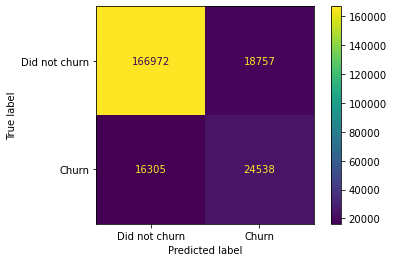

In [12]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not churn", "Churn"])

In [13]:
df_original['Probability_of_churn_XGBoost'] = clf_xgb.predict_proba(X_encoded[X_test.columns])[:,1]

#pd.DataFrame(X_encoded['Probability_of_churn_CatBoost'].head(20))
#X_encoded['Probability_of_churn_CatBoost'].describe()

pd.DataFrame(df_original[['NIF', 'Probability_of_churn_XGBoost', 'Flag_apo_anul']].head(10))

,NIF,Probability_of_churn_XGBoost,Flag_apo_anul
0,163967415.0,0.369869,0
1,219467382.0,0.452412,0
2,225366983.0,0.107956,0
3,122585330.0,0.083714,0
4,225276313.0,0.345147,1
5,177579226.0,0.258829,0
6,204469821.0,0.342033,0
7,222627581.0,0.976528,1
8,204048770.0,0.220688,0
9,184309930.0,0.997425,1


In [14]:
#import shap

#explainer = shap.Explainer(clf_xgb)
#shap_values = explainer(X_train)

#shap.plots.waterfall(shap_values[0])

In [15]:
#imp = pd.DataFrame({'imp': clf_xgb.feature_importances_, 'name':X_encoded.columns}).sort_values('imp')
#imp

In [16]:
clf_xgb = xgb.XGBClassifier(seed=42, 
                            objective='binary:logistic',
                            gamma=0.25,
                           learn_rate=0.1,
                           max_depth=4,
                           reg_lambda=2,
                           scale_pos_weight=3,
                           subsample=0.9,
                           colsample_bytree=0.5,
                           n_estimators=1)
clf_xgb.fit(X_train, y_train)

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="2,2",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

C:\Users\v082327\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:36:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'anuidades': 1, 'saldo_cliente': 2, 'bonus': 1, 'Last_Accident': 2, 'MODO_RENOVACAO_A': 2, 'prcomanl_ob': 1, 'Tipo_Fraccionamento': 1, 'LISTA_NEGRA': 1, 'produto_marca_Família': 2}
gain:  {'anuidades': 77803.25, 'saldo_cliente': 19472.5752, 'bonus': 4167.51953, 'Last_Accident': 1697.21655, '

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

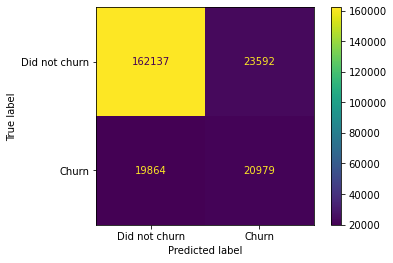

In [17]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not churn", "Churn"])